<a href="https://colab.research.google.com/github/nicolaiberk/llm_ws/blob/main/notebooks/02_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scaling Word Embeddings & Document Embeddings

In [1]:
!pip install gensim # restart after installation


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np

## Calculating Projections and Cosine Similarity

In [3]:
## again we load the 100-dimensional GloVe model trained on Wikipedia data
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100')

We can calculate the projection of vector a on a given vector b by using the dot product, divided by the magnitude of vector b:

In [4]:
## calculate dot product
from numpy import dot
from numpy.linalg import norm

def proj_mag(a, b):
    return dot(a, b) / norm(b)

proj_mag(wv['nurse'], wv['woman'])

3.328134

But cosine similarity is a lot easier to interpret, since it is bounded [-1,1]:

In [5]:
def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

cos_sim(wv['nurse'], wv['woman'])

0.61394423

As you have seen in the first tutorial, there is also a function in the `gensim`-package to calculate the cosine similarity:

In [6]:
wv.similarity('nurse', 'woman')

0.61394423

## Defining Scales

An association of a given word might not tell us much, especially because opposite concepts are often located close to each other in the vector space. Rather than the association of two words, we might often be interested in the relative position of a concept on a pre-defined scale. We can create such a scale by subtracting the negative pole of that scale from the positive pole. You have seen this concept being used already when we calculated the word vector for 'berlin' from the vectors for 'paris', 'france', and 'germany'. Try to imagine this subtraction in the vector space.

By calculating the magnitude of the projection of a given word to this defined axis, we can identify the position this word has relative to this scale. This visualization from the Kozlowski paper might be helpful to understand this concept:

![](https://www.dropbox.com/scl/fi/fy9ihaxiwiql2c0s13vjy/projection_example.png?rlkey=aszlo5mp3rdzy4svawug5eybl&dl=1)

You can hence create pretty much any scale by defining two poles for it, subtracting the negative from the positive pole, and calculating the magnitude of the projection:

In [7]:
## simple scaling, projection magnitude
fr_de_scale = wv['french'] - wv['german']
print("Frenchness of Paris: ", proj_mag(wv['paris'], fr_de_scale))
print("Frenchness of Lausanne: ", proj_mag(wv['lausanne'], fr_de_scale))
print("Frenchness of Bern: ", proj_mag(wv['bern'], fr_de_scale))
print("Frenchness of Berlin: ", proj_mag(wv['berlin'], fr_de_scale))

Frenchness of Paris:  1.8724234
Frenchness of Lausanne:  0.38790774
Frenchness of Bern:  -0.8462114
Frenchness of Berlin:  -1.8756536


As mentioned, the boundedness of the cosine similarity [-1,1] makes it a lot more interpretable:

In [8]:
## simple scaling, cosine similarity
fr_de_scale = wv['french'] - wv['german']
print("Frenchness of Paris: ", cos_sim(wv['paris'], fr_de_scale))
print("Frenchness of Lausanne: ", cos_sim(wv['lausanne'], fr_de_scale))
print("Frenchness of Bern: ", cos_sim(wv['bern'], fr_de_scale))
print("Frenchness of Berlin: ", cos_sim(wv['berlin'], fr_de_scale))

Frenchness of Paris:  0.29809454
Frenchness of Lausanne:  0.0726039
Frenchness of Bern:  -0.17677024
Frenchness of Berlin:  -0.3329


In practice, it is better to create a scale from an averaged vector of multiple pole words (often referred to as the 'centroid'). To do so, we define our pole words and average across their vectors:

In [9]:
## start by defining dictionaries (usually larger than 3-4 words)
rich_words = ['rich', 'wealthy', 'wealth', 'billionaire']
poor_words = ['poor', 'broke', 'poverty', 'beggar']

female_words = ['female', 'woman', 'feminine']
male_words = ['male', 'man', 'masculine']

In [10]:
## pro tip: you can extend your dictionaries with embeddings!
wv.most_similar(positive=rich_words, topn=5)

[('fortune', 0.6519295573234558),
 ('richest', 0.6483081579208374),
 ('money', 0.620699405670166),
 ('vast', 0.6197866201400757),
 ('businessman', 0.619742751121521)]

In [11]:
## create mean vectors for your concepts of interest
rich_vec = np.mean(wv[rich_words], axis = 0)
poor_vec = np.mean(wv[poor_words], axis = 0)

female_vec = np.mean(wv[female_words], axis = 0)
male_vec = np.mean(wv[male_words], axis = 0)

Try to imagine what these vectors look like in the vector space, relative to the dictionary terms. These vectors can already be informative in themselves, given that they are designed to represent the essence of a concept:

In [12]:
cos_sim(wv['nurse'], female_vec)

0.5050167

In [13]:
cos_sim(wv['nurse'], male_vec)

0.4016291

And the differences of cosine similarities are often used in research:

In [14]:
## cosine similarity difference
nurse_mf_cos = cos_sim(wv['nurse'], female_vec) - cos_sim(wv['nurse'], male_vec)
teacher_mf_cos = cos_sim(wv['teacher'], female_vec) - cos_sim(wv['teacher'], male_vec)
lifeguard_mf_cos = cos_sim(wv['lifeguard'], female_vec) - cos_sim(wv['lifeguard'], male_vec)
banker_mf_cos = cos_sim(wv['banker'], female_vec) - cos_sim(wv['banker'], male_vec)
miner_mf_cos = cos_sim(wv['miner'], female_vec) - cos_sim(wv['miner'], male_vec)

print("Association of 'nurse' with female (vs. male) terms: ", nurse_mf_cos)
print("Association of 'teacher' with female (vs. male) terms: ", teacher_mf_cos)
print("Association of 'lifeguard' with female (vs. male) terms: ", lifeguard_mf_cos)
print("Association of 'banker' with female (vs. male) terms: ", banker_mf_cos)
print("Association of 'miner' with female (vs. male) terms: ", miner_mf_cos)

Association of 'nurse' with female (vs. male) terms:  0.103387594
Association of 'teacher' with female (vs. male) terms:  0.023278862
Association of 'lifeguard' with female (vs. male) terms:  0.0648001
Association of 'banker' with female (vs. male) terms:  -0.034258217
Association of 'miner' with female (vs. male) terms:  -0.0060281903


However, the neat nature of projections is that they can capture a vectors' position on that very scale. To calculate them, we first need subtract the poles from each other to create the axes:

In [15]:
## define axes
gender_axis = female_vec - male_vec
rich_axis = rich_vec - poor_vec

... and calculate the cosine similarities:

In [16]:
import numpy as np
import pandas as pd

scaled_occupations = pd.DataFrame(
    [['Nurse', 'Teacher', 'Lifeguard', 'Banker', 'Miner'],
    [
        cos_sim(wv['nurse'], gender_axis),
        cos_sim(wv['teacher'], gender_axis),
        cos_sim(wv['lifeguard'], gender_axis),
        cos_sim(wv['banker'], gender_axis),
        cos_sim(wv['miner'], gender_axis)
    ],
    [
        cos_sim(wv['nurse'], rich_axis),
        cos_sim(wv['teacher'], rich_axis),
        cos_sim(wv['lifeguard'], rich_axis),
        cos_sim(wv['banker'], rich_axis),
        cos_sim(wv['miner'], rich_axis)
    ]]
).T.rename(columns={0:'Occupation', 1:'Gender score', 2:'Economic Score'})

In [17]:
scaled_occupations

,Occupation,Gender score,Economic Score
0,Nurse,0.379125,-0.24585
1,Teacher,0.160878,-0.117471
2,Lifeguard,0.196767,-0.295412
3,Banker,-0.049261,0.455049
4,Miner,0.027395,0.13554


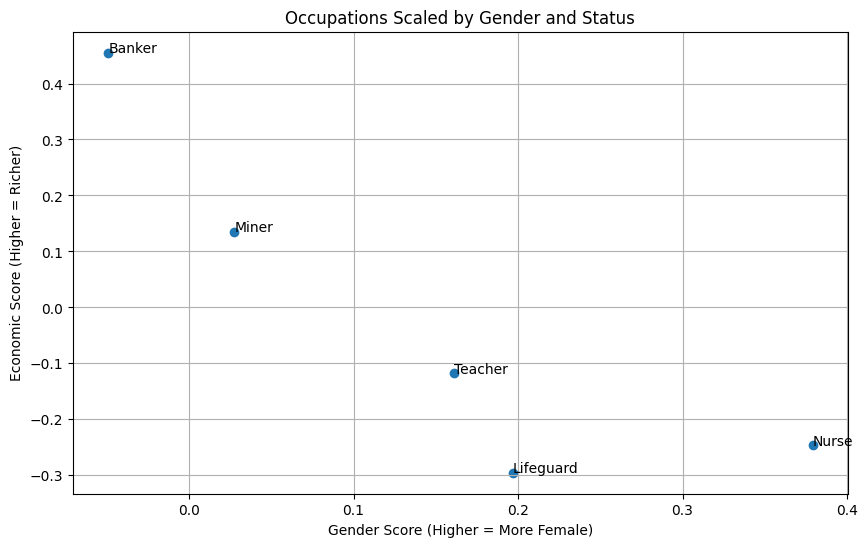

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(scaled_occupations['Gender score'], scaled_occupations['Economic Score'])

# Add labels and title
plt.xlabel('Gender Score (Higher = More Female)')
plt.ylabel('Economic Score (Higher = Richer)')
plt.title('Occupations Scaled by Gender and Status')

# Add text labels for each point
for i, row in scaled_occupations.iterrows():
    plt.text(row['Gender score'], row['Economic Score'], row['Occupation'])

plt.grid(True)
plt.show()

In practice, both approaches (differences in cosine similarities and the cosine similarity relative to a scale) lead to almost identical scores:

In [19]:
scaled_occupations['cos_dif_gender'] = [nurse_mf_cos, teacher_mf_cos, lifeguard_mf_cos, banker_mf_cos, miner_mf_cos]
scaled_occupations[['Gender score', 'cos_dif_gender']].corr()

,Gender score,cos_dif_gender
Gender score,1.000000,0.980181
cos_dif_gender,0.980181,1.000000


## Document Embeddings

We'll return to the adapted dataset of dialogue in the Simpsons from [Kaggle](https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset?resource=download&select=simpsons_script_lines.csv). This time, we estimate a model with document embeddings indicating the character who provided the line. This allows us to create semantic vectors for each character in the same space as the word embeddings.

Again, we load and clean our texts:

In [20]:
## load data
import pandas as pd
dataset = pd.read_csv('https://www.dropbox.com/scl/fi/n5ffxvm4qyjkp8ws7qgoq/simpsons_script_lines_clean.csv?rlkey=gfliitwgi8cqsjxlcdmmdwtym&dl=1')
dataset['cleaned_text'] = dataset['spoken_words'].str.replace('[^a-zA-Z ]','', regex=True) # remove anything that is not a letter or whitespace
dataset['cleaned_text'] = dataset['cleaned_text'].str.lower() # lowercase
dataset['cleaned_text'] = dataset['cleaned_text'].str.replace(' +', '') # remove multiple whitespaces
dataset = dataset[dataset['cleaned_text'] != '']
dataset.loc[:,'cleaned_text'] = dataset['cleaned_text'].astype(str)
dataset.cleaned_text.head()

0    no actually it was a little of both sometimes ...
1                                  wheres mr bergstrom
2    i dont know although id sure like to talk to h...
3                            that life is worth living
4    the polls will be open from now until the end ...
Name: cleaned_text, dtype: object

We then need to prepare this data for the Doc2Vec-model. Remember that, alongside the vector indicating context words, a vector indicating the document ID is passed. We need to concatenate all texts per speaker in order to create a single 'document' for each speaker. Then, we split those documents into tokens of interest (in our case words, similar to the word2vec model) and use  `gensim`'s `TaggedDocument`-class to pass the information about the speaker:

In [21]:
## concatenate all cleaned texts from the same speaker and tag documents (this runs a bit)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
character_texts = list()
for speaker in dataset.raw_character_text.unique():
    print('Preparing texts from ', speaker, '...')
    concat_text = ' '.join(dataset[dataset.raw_character_text == speaker].cleaned_text)
    character_texts.append(TaggedDocument(concat_text.split(" "), [speaker]))

Preparing texts from  Miss Hoover ...
Preparing texts from  Lisa Simpson ...
Preparing texts from  Edna Krabappel-Flanders ...
Preparing texts from  Martin Prince ...
Preparing texts from  Bart Simpson ...
Preparing texts from  nan ...
Preparing texts from  Landlady ...
Preparing texts from  Nelson Muntz ...
Preparing texts from  Terri/sherri ...
Preparing texts from  Milhouse Van Houten ...
Preparing texts from  Wendell Borton ...
Preparing texts from  Kid Reporter ...
Preparing texts from  Conductor ...
Preparing texts from  BERGSTROM ...
Preparing texts from  Homer Simpson ...
Preparing texts from  Marge Simpson ...
Preparing texts from  Ned Flanders ...
Preparing texts from  Moe Szyslak ...
Preparing texts from  Barney Gumble ...
Preparing texts from  Dr. Julius Hibbert ...
Preparing texts from  Husband Of Marge's Friend ...
Preparing texts from  Maude Flanders ...
Preparing texts from  Sophisticate #1 ...
Preparing texts from  Sophisticate #2 ...
Preparing texts from  Sophisticate

Each document then contains all words uttered from a given character, as well as an indicator for the character:

In [22]:
character_texts[1100]

TaggedDocument(words=['can', 'we', 'see', 'the', 'elephant', 'ah', 'this', 'is', 'countrytime', 'lemonade', 'mix', 'theres', 'never', 'been', 'anything', 'close', 'to', 'a', 'lemon', 'in', 'it', 'i', 'swear'], tags=['Small Kid'])

Time to define our model and train it on these documents!

In [23]:
model = Doc2Vec(vector_size=300, min_count=2, epochs=40)

In [24]:
## estimate doc2vec model (this takes some patience)
model.build_vocab(character_texts)
model.train(character_texts, total_examples=model.corpus_count, epochs=model.epochs)

This results in a model with both word and document embeddings. These can be accessed via `model.dv`:

In [25]:
model.dv['Homer Simpson'].shape

(300,)

In [26]:
model.wv['donut'].shape

(300,)

Crucially, the document embeddings are learned into the same vector space as the word embeddings. This means we can assess which words are associated with this character, meaning which words are similar in meaning as the learned the meaning of the character (note that words are predictive of words used by the character - they might not even be used by the characters themselves).

In [27]:
model.wv.most_similar(model.dv['Homer Simpson'], topn=5)

[('pita', 0.33525341749191284),
 ('bronchitis', 0.306993693113327),
 ('mcnuggets', 0.2957395911216736),
 ('funny', 0.2862647771835327),
 ('stupid', 0.28378644585609436)]

In [28]:
model.wv.most_similar(model.dv['Lisa Simpson'], topn=5)

[('dad', 0.4581497013568878),
 ('angry', 0.40807291865348816),
 ('mom', 0.33777719736099243),
 ('stacy', 0.3339071273803711),
 ('maybe', 0.3261108696460724)]

Of course, we can also plot the positions of different characters in our vector space:

In [29]:
## run a dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(model.dv[model.dv.index_to_key])
dv_2d = pca.transform(model.dv[model.dv.index_to_key])
dv_2d = pd.DataFrame(dv_2d, index = model.dv.index_to_key)

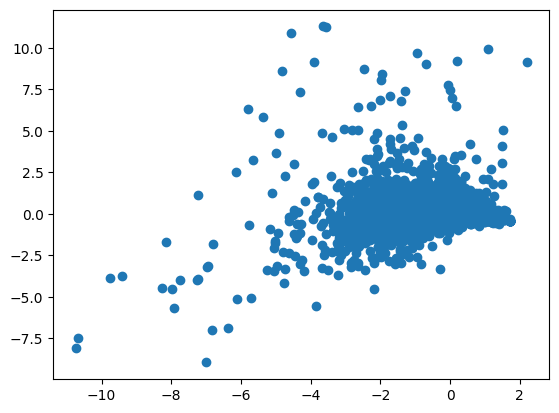

In [30]:
import matplotlib.pyplot as plt
import random
random.seed(0)

plt.scatter(dv_2d[0], dv_2d[1])
plt.show()

And scale them:

In [31]:
cool_boring_scale = model.wv['cool'] - model.wv['boring']
print("Coolness of Homer: ", cos_sim(model.dv['Homer Simpson'], cool_boring_scale))
print("Coolness of Bart: ", cos_sim(model.dv['Bart Simpson'], cool_boring_scale))

Coolness of Homer:  0.011415758
Coolness of Bart:  0.13060087


In [32]:
## ...or predict vectors for new documents...
new_document = [
    "it", "wont", "last", "brothers", "and", "sisters", "are", "natural",
    "enemies", "like", "englishmen", "and", "scots", "or", "welshmen", "and",
    "scots", "or", "japanese", "and", "scots", "or", "scots", "and", "other",
    "scots", "damn", "scots", "they", "ruined", "scotland"
]
vector= model.infer_vector(new_document)

In [33]:
## ...and compare them
model.dv.most_similar([vector], topn=5)

[('Party Goers', 0.586698055267334),
 ('Parent Two', 0.586370050907135),
 ('Japanese Phoebe', 0.5846120715141296),
 ('Young Husband', 0.5817421078681946),
 ('Kids In Audience', 0.5804868340492249)]

## Exercise

1) You are interested in the political leaning of the characters. How could you measure their political leaning, based on their language?

2) Define dictionaries to measure your concept of interest.

3) Create a scale (or if you are very eager, two). Select some characters of interest that you would like to scale. Calculate the cosine similarity of their vectors relative to the scale.

4) Create a table of the political leanings of your characters. What do you observe? Who do you think might vote republican?

5) Estimate the poltiical leaning of all characters and create a plot of their distribution.